### TODO
- Manage NA values
- Manage useless features
    - `year` : merge with name
    - `link`, `logo` : delete
- Looking for strange values
    - score_i > score_j && rank_i > rank_j
- Using pandas categories
    - `country`, `city`, `region`
    - `type`, `size`, `research_ouptut`
- Looking for correlation between features


### Rapport du prof
- Tester différentes métriques
- Modèles à utiliser :
    - Linear model 
    - XGBoost ++
    - Decision tree
- Visualiser les données (matrice de corrélation)


### Notebook settings and imports

In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import is_object_dtype, is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data_init = pd.read_csv("qs-world-university-rankings-2017-to-2022-V2.csv")
N_init, D_init = data_init.shape
data_init.head()

,university,year,rank_display,score,link,country,city,region,logo,type,research_output,student_faculty_ratio,international_students,size,faculty_count
0,Massachusetts Institute of Technology (MIT),2017,1,100.0,https://www.topuniversities.com/universities/m...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,4.0,"3,730",M,"3,065"
1,Stanford University,2017,2,98.7,https://www.topuniversities.com/universities/s...,United States,Stanford,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,3.0,"3,879",L,"4,725"
2,Harvard University,2017,3,98.3,https://www.topuniversities.com/universities/h...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,5.0,"5,877",L,"4,646"
3,University of Cambridge,2017,4,97.2,https://www.topuniversities.com/universities/u...,United Kingdom,Cambridge,Europe,https://www.topuniversities.com/sites/default/...,Public,Very high,4.0,"7,925",L,"5,800"
4,California Institute of Technology (Caltech),2017,5,96.9,https://www.topuniversities.com/universities/c...,United States,Pasadena,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,2.0,692,S,968


In [3]:
data_init.isna().sum()

university                   0
year                         0
rank_display                68
score                     3662
link                         0
country                      0
city                       178
region                       0
logo                         0
type                        12
research_output              2
student_faculty_ratio       75
international_students     164
size                         2
faculty_count               78
dtype: int64

### Clean-up : useless features

In [4]:
# drop useless columns
useless_columns = [
    "link",
    "logo"
]
data = data_init.drop(columns=useless_columns, axis=1)

# merge year with university's name
university_with_year = data["university"] + data["year"].map(" ({})".format)
data.insert(0, "univesity_with_year", university_with_year)
    # data = data.drop(columns=["university", "year"], axis=1)

In [5]:
# On change les N-M en N

rank_display_raw = data["rank_display"].map(lambda rank: str(rank).split("-")[0], na_action='ignore')
rank_display_raw = rank_display_raw.fillna(0)  # pour pouvoir convertir en entier
rank_display_raw = rank_display_raw.astype('int64')

data.insert(4, "rank_display_raw", rank_display_raw)

### Clean-up : NA values

In [6]:
def fill_score_if_possible():
    """
    regarder par année :
        - Regrouper par rangs 
        - Regarder s'il y a une valeur quelque part
            - S'il y en a plusieurs, vérifier si elles sont égales
        - Remplir les autres de cette valeur 

    de 3662 à 3533 NA
    """

    years = data["year"].unique()
    
    for year in years:
        # Regarder par année
        data_year = data.loc[data["year"] == year]

        ranks = data_year["rank_display"].unique()
        for rank in ranks:
            # Regrouper par rangs
            data_year_rank = data_year.loc[data["rank_display"] == rank]

            # S'il y a des égalités, on regarde s'il y a des valeurs manquantes
            # Si oui, on rempli par la moyenne des valeurs de la même catégorie
            if data_year_rank.shape[0] > 1:
                data_year_rank_scores = data_year_rank["score"]
                if data_year_rank_scores.isna().sum() > 0:
                    data.loc[
                        (data["year"] == year) & (data["rank_display"] == rank),
                        "score"
                    ] = data_year_rank_scores.mean()
            
fill_score_if_possible()


In [11]:
data.isna().sum().loc[data.isna().sum() > 0]

data_with_na = data.loc[data.isna().any(axis=1)]
data_count_na_by_row = data_with_na.isna().sum(axis=1)
data_count_na_by_row.sort_values(ascending=False)

max_na_count = 5
data_with_too_much_na_idxs = data_count_na_by_row.loc[data_count_na_by_row >= max_na_count].index

data.drop(data_with_too_much_na_idxs, inplace=True)

data.dropna(axis = 0, how = "any", subset = ["international_students", "faculty_count"], inplace = True)

### Converting objects to categorical

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6298 entries, 0 to 6481
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   univesity_with_year     6298 non-null   object 
 1   university              6298 non-null   object 
 2   year                    6298 non-null   int64  
 3   rank_display            6267 non-null   object 
 4   rank_display_raw        6298 non-null   int64  
 5   score                   2896 non-null   float64
 6   country                 6298 non-null   object 
 7   city                    6132 non-null   object 
 8   region                  6298 non-null   object 
 9   type                    6288 non-null   object 
 10  research_output         6298 non-null   object 
 11  student_faculty_ratio   6281 non-null   float64
 12  international_students  6298 non-null   int64  
 13  size                    6298 non-null   object 
 14  faculty_count           6298 non-null   

In [13]:
#international_students and faculty_count are integers
#in string form so they need to be converted
print(data["international_students"])
print(data["faculty_count"])

0       3730
1       3879
2       5877
3       7925
4        692
        ... 
6477      57
6478     585
6479    2826
6480    2394
6481    2300
Name: international_students, Length: 6298, dtype: int64
0       3065
1       4725
2       4646
3       5800
4        968
        ... 
6477    1174
6478    3504
6479    1113
6480    1688
6481    5871
Name: faculty_count, Length: 6298, dtype: object


In [14]:
for col in ["international_students", "faculty_count"]:
    if is_object_dtype(data[col]):
        data[col] = data[col].str.replace(',', '')
        data[col] = data[col].str.replace('.', '')
        data[col] = [int(x) for x in data[col]]

C:\Users\padda\AppData\Local\Temp/ipykernel_3316/1064600894.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[col] = data[col].str.replace('.', '')


In [15]:
print(data["international_students"])
print(data["faculty_count"])

0       3730
1       3879
2       5877
3       7925
4        692
        ... 
6477      57
6478     585
6479    2826
6480    2394
6481    2300
Name: international_students, Length: 6298, dtype: int64
0       3065
1       4725
2       4646
3       5800
4        968
        ... 
6477    1174
6478    3504
6479    1113
6480    1688
6481    5871
Name: faculty_count, Length: 6298, dtype: int64


In [16]:
#In some columns different caps lead to different categories
#So before assigning categories everything is lowercased

for col in data.columns:
    if is_object_dtype(data[col]):
        data[col] = data[col].str.lower().astype('category')
        #print(data[col].cat.categories)
        data[col] = data[col].cat.codes + 1

### Visualizing data



<AxesSubplot:>

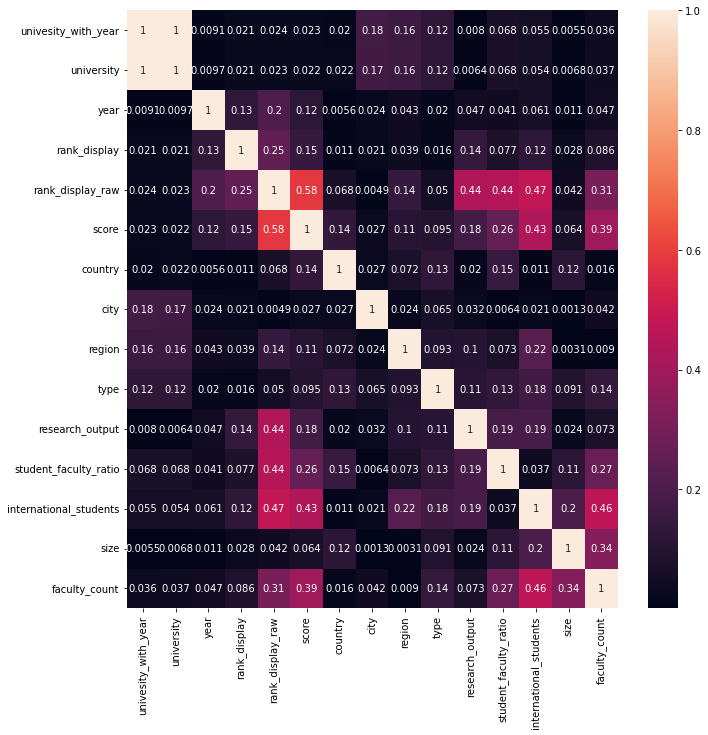

In [17]:
data_corr = data.corr()
plt.figure(figsize = (11,11))
sns.heatmap(abs(data_corr), annot = True)